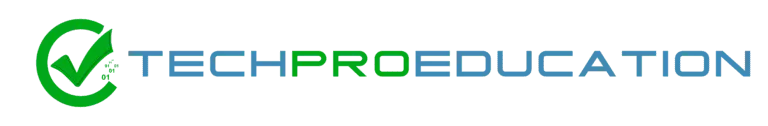

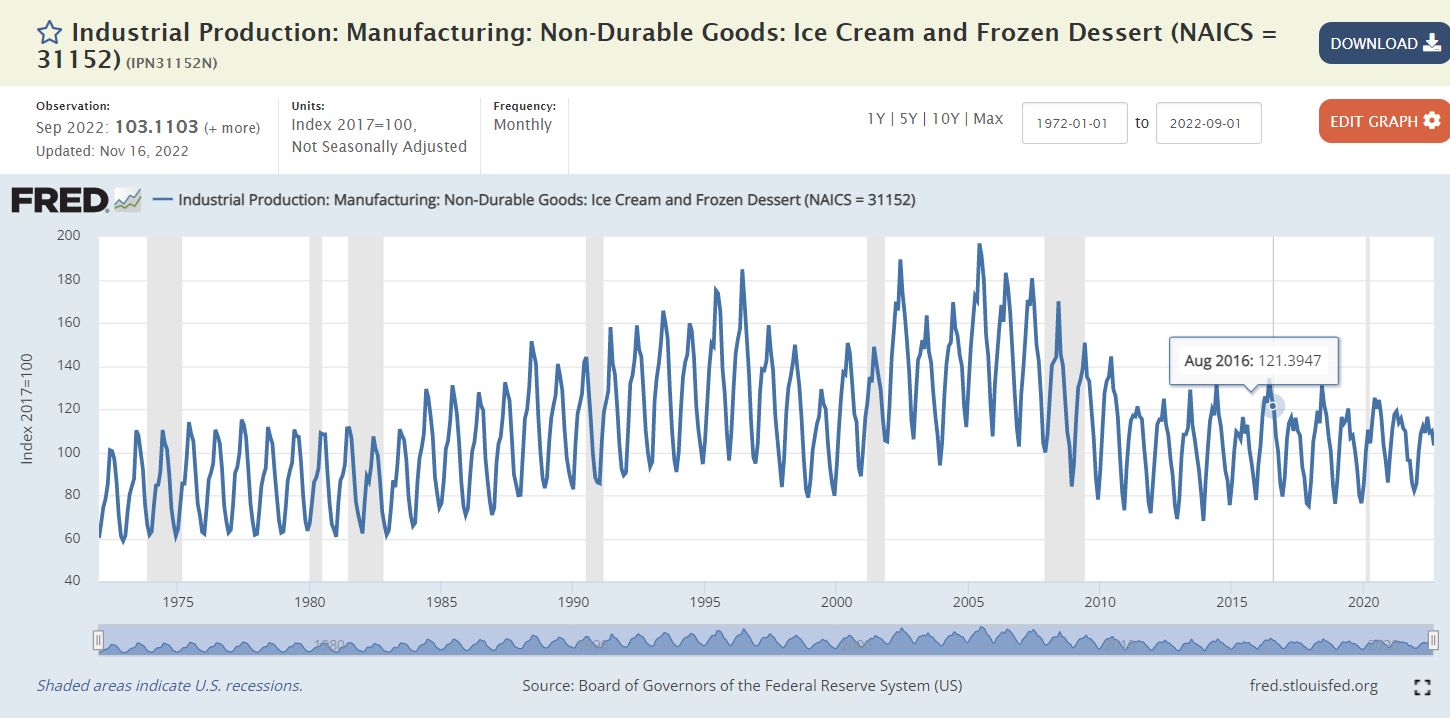

# Dataset Info

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

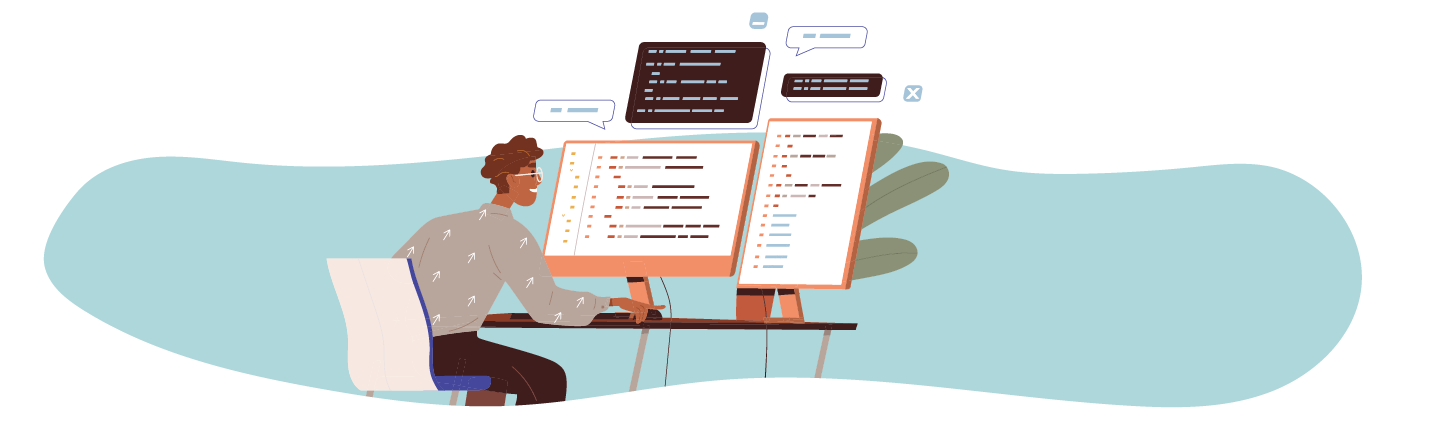

# Import Libraries

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)

sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set it None to display all rows in the dataframe
# pd.set_option('display.max_rows', None)

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [6]:
df = pd.read_csv('Frozen_Dessert_Production.csv',
                 index_col='DATE',
                 parse_dates=True
                )

# Indest Data

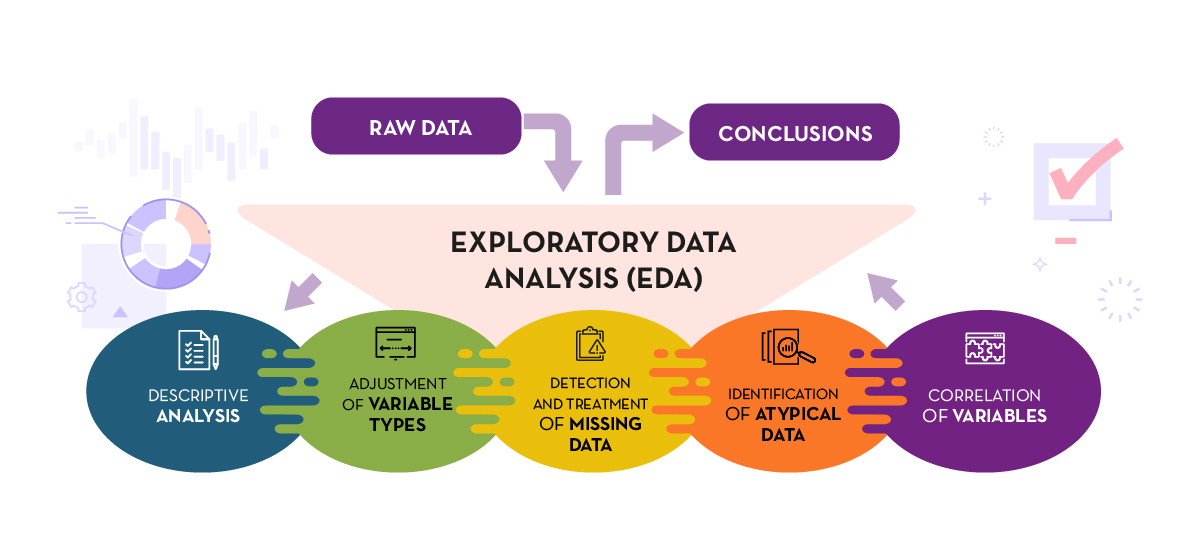

# Exploratory Data Analysis and Visualization

In [7]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


In [57]:
df.tail()

,Production
DATE,
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263
2019-08-01,102.609
2019-09-01,101.587


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [9]:
df.columns = ['Production']

In [10]:
df.head()

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764


<AxesSubplot:xlabel='DATE'>

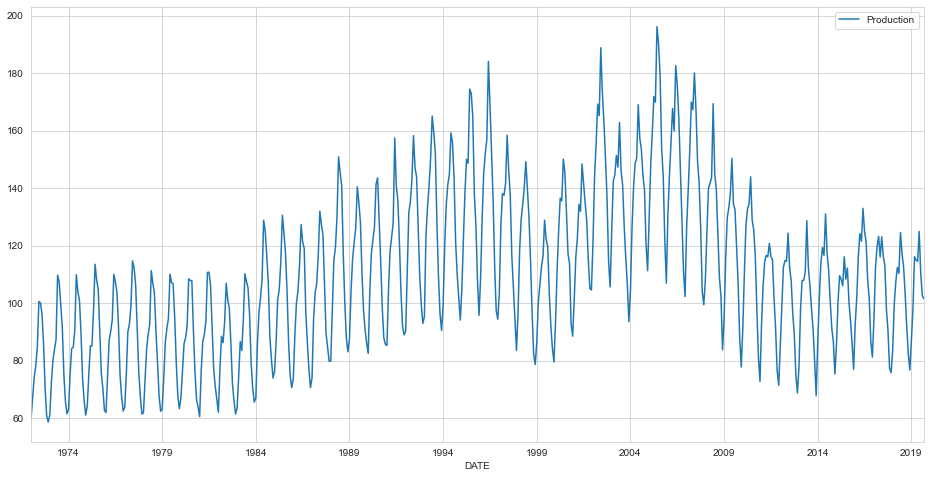

In [11]:
df.plot(figsize=(16,8))

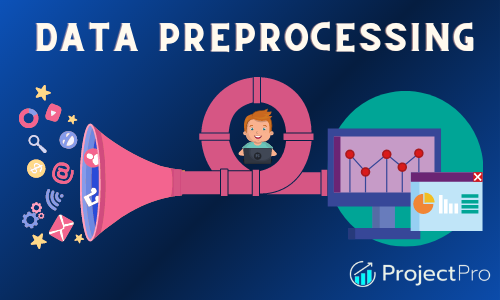

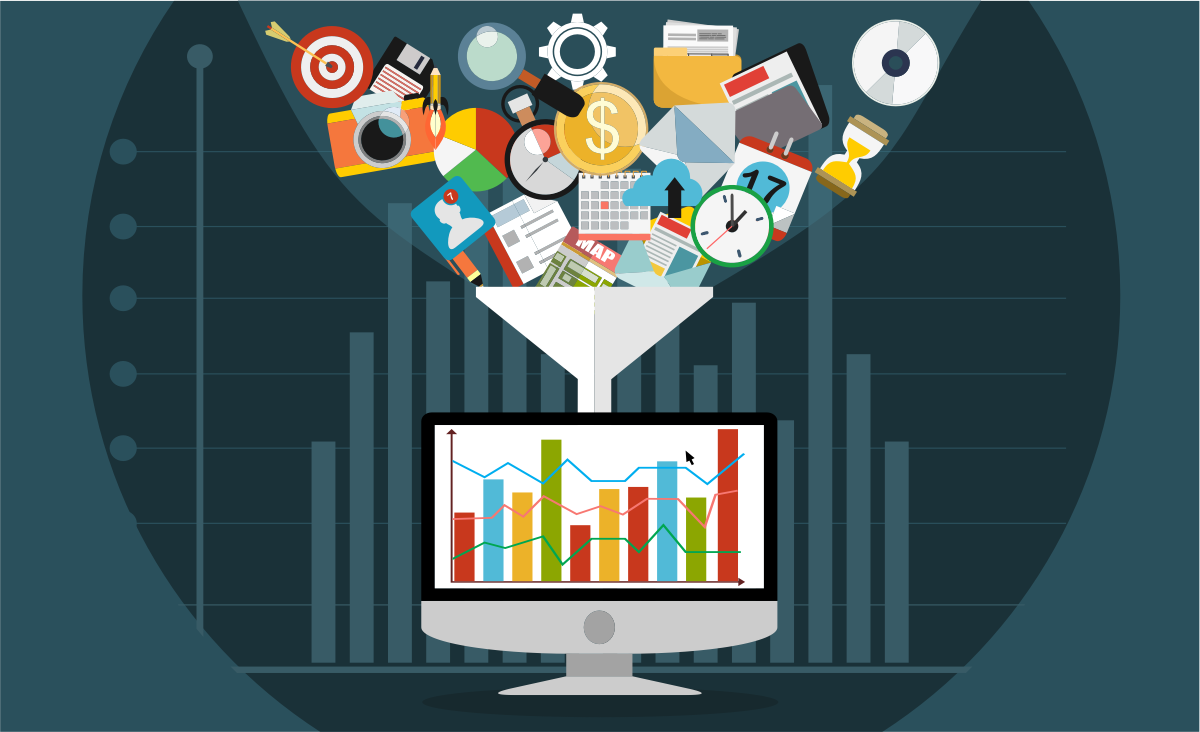

# Preprocessing of Data

## Train Test Split

In [12]:
test_size = 24

In [13]:
test_ind = len(df)- test_size

In [14]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

#TRAIN TEST DIYE AYIRDIK

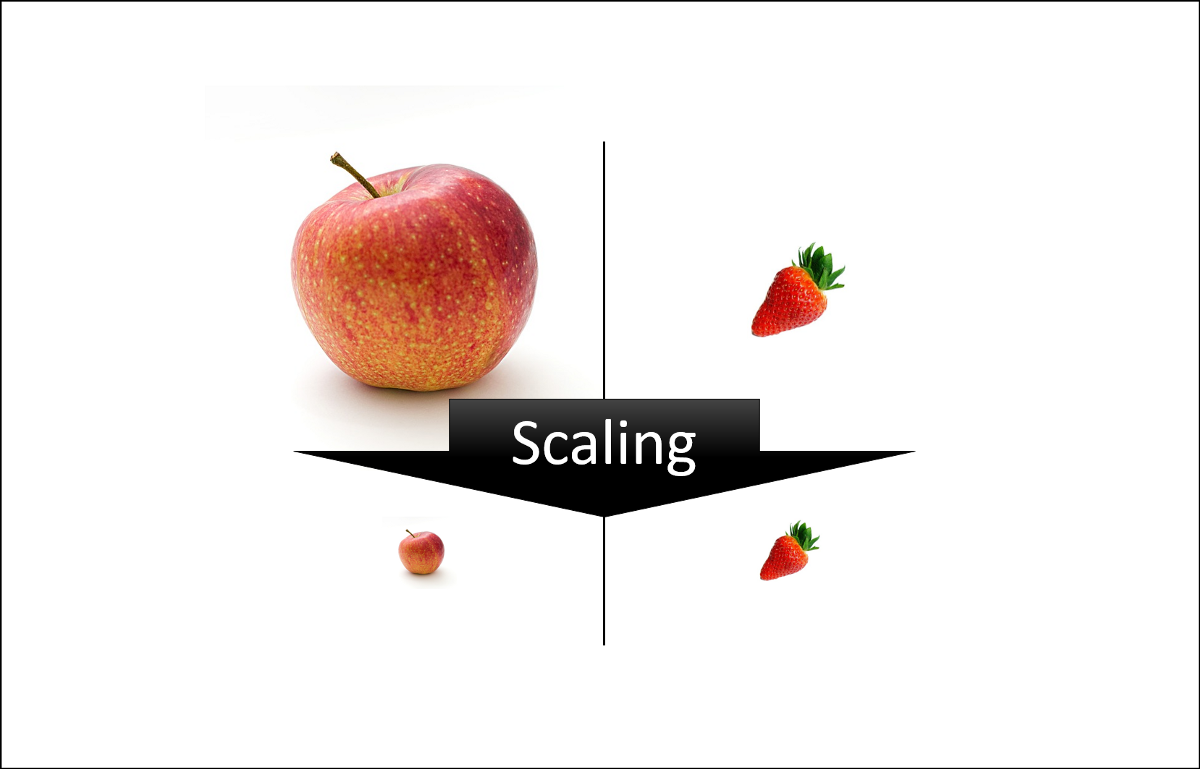

## Scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler()

# burda bunu yaptk robus scaling te yapilabilir

In [17]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

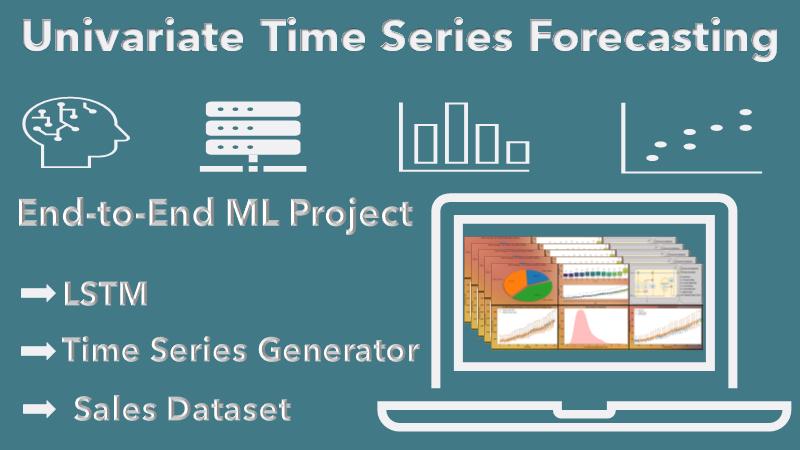

## Time Series Generator

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# help(TimeseriesGenerator)

In [20]:
length = 12 #12 satir degerlendir 13ü tahmin et, eger bu 120 olsa belki öncekileri hatirlayamayacak, bir fotoda vardi top icinde her bir öncekinin degri vardi, 30 a kadar tavsiye edilir 12,24,30
batch_size = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = batch_size)
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = batch_size)

#train datasinda kendi ögreniyor, ve en son 12 yi alip 13ü tahmin  ediyor,
# urda datanin modele girebilmesi icin hazirliyor
#cok featuresli olanlarda biraz farkli

In [21]:
X, y = generator[0]

In [22]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.00947104 0.06108982 0.11326273 0.14145625 0.18982663 0.30495972
 0.30154406 0.27416065 0.19736841 0.08532665 0.01561588 0.        ]
Predict this y: 
 [[0.01774221]]


# Modelling & Model Performance

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
n_features = train_scaled.shape[1]

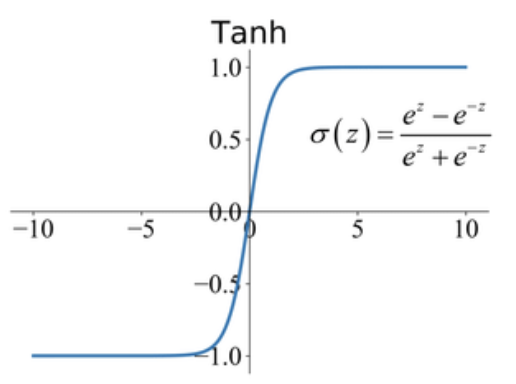

## with "tanh" activation function

In [25]:
model = Sequential()
model.add(LSTM(64, activation = 'tanh', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(16, activation = 'tanh'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

#LSTM ve tanjant kullanilmis galiba asagida relu ile yapilip sonuclar karsilastirilmis
#burda nöronlari arttirmaktansa hidden layerlari arttirmak daha iyi olacagi söyleniyor


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 64)            16896     
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [27]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [28]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 20s 25ms/step - loss: 0.0258 - val_loss: 0.0074
Epoch 2/20
537/537 [==============================] - 11s 20ms/step - loss: 0.0120 - val_loss: 0.0026
Epoch 3/20
537/537 [==============================] - 11s 20ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 4/20
537/537 [==============================] - 10s 18ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 5/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 6/20
537/537 [==============================] - 9s 16ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 7/20
537/537 [==============================] - 9s 16ms/step - loss: 0.0048 - val_loss: 0.0019
Epoch 8/20
537/537 [==============================] - 9s 17ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 9/20
537/537 [==============================] - 9s 16ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 10/20
537/537 [==============================] - 9s 18ms/step - loss: 0.0046 - va

<AxesSubplot:>

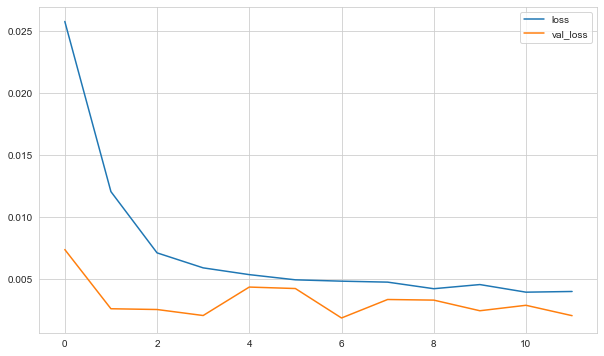

In [29]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()
#birbirine yakin sonuclar cikmis

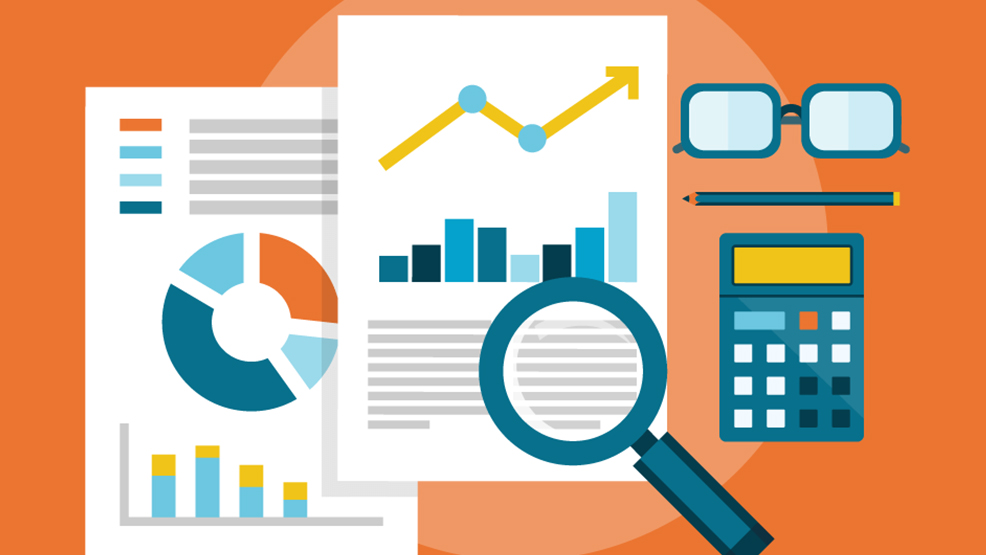

### Evaluation on Test Data

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [31]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\nmae:", mae, "\nmse:",mse, "\nrmse:",rmse)

In [32]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [33]:
predictions = scaler.inverse_transform(predictions_scaled)

In [34]:
compare = test[:12]
compare['Predictions_tanh'] = predictions
compare

,Production,Predictions_tanh
DATE,,
2017-10-01,90.473,92.099
2017-11-01,77.438,87.203
2017-12-01,75.812,92.049
2018-01-01,83.434,102.159
2018-02-01,99.490,111.187
2018-03-01,107.315,117.221
2018-04-01,112.431,121.662
2018-05-01,110.354,123.740
2018-06-01,124.584,124.288


<AxesSubplot:xlabel='DATE'>

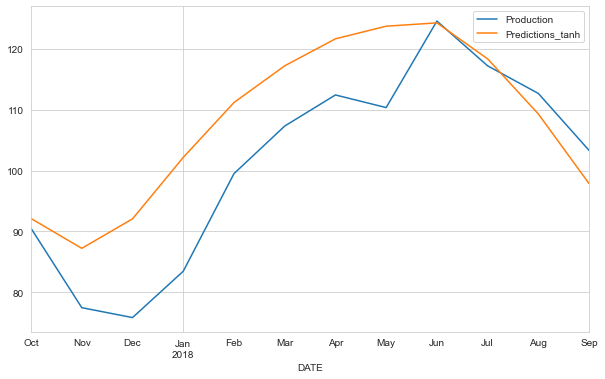

In [35]:
compare.plot()

In [36]:
eval_metrics(compare.Production, compare.Predictions_tanh)

r2_score: 0.5567854145311757 
mae: 8.404447287413722 
mse: 104.51916764291083 
rmse: 10.22346162720391


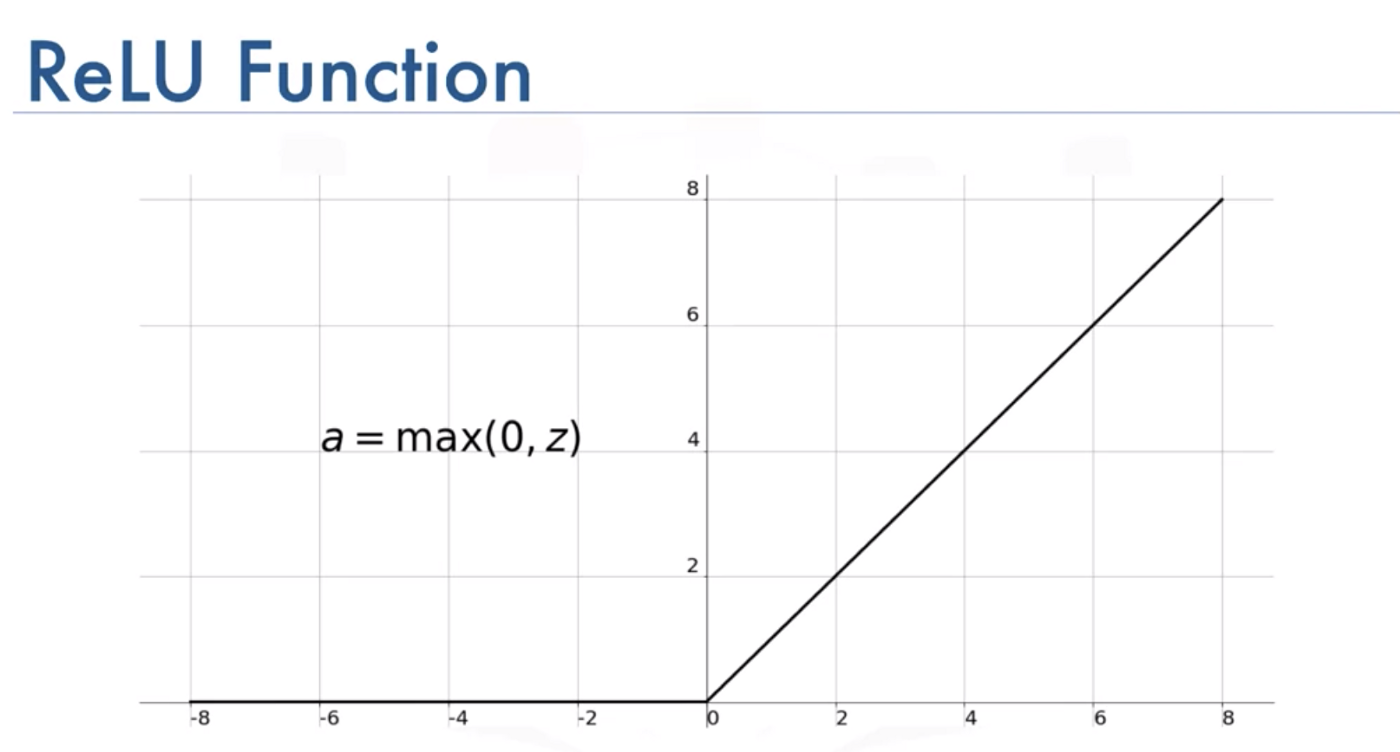

## with "relu" activation function

In [37]:
model = Sequential()
model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')
#burda relu ile yapalim demisler

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 12, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 12, 32)            12416     
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________


In [39]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

In [40]:
model.fit_generator(generator,
                    epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
537/537 [==============================] - 12s 15ms/step - loss: 0.0345 - val_loss: 0.0067
Epoch 2/20
537/537 [==============================] - 7s 13ms/step - loss: 0.0117 - val_loss: 0.0018
Epoch 3/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0093 - val_loss: 0.0037
Epoch 4/20
537/537 [==============================] - 9s 16ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 5/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 6/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0073 - val_loss: 0.0013
Epoch 7/20
537/537 [==============================] - 8s 14ms/step - loss: 0.0068 - val_loss: 0.0020
Epoch 8/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0063 - val_loss: 0.0016
Epoch 9/20
537/537 [==============================] - 8s 15ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 10/20
537/537 [==============================] - 7s 14ms/step - loss: 0.0063 - val_l

<AxesSubplot:>

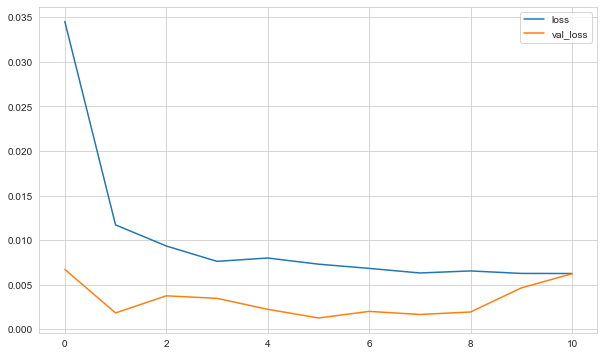

In [41]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

### Evaluation on Test Data

In [42]:
predictions_scaled = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)
    
    # store prediction
    predictions_scaled.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis=1)

### Inverse Transformation and Comparing

In [43]:
predictions = scaler.inverse_transform(predictions_scaled)

In [44]:
compare['Predictions_relu'] = predictions
compare

,Production,Predictions_tanh,Predictions_relu
DATE,,,
2017-10-01,90.473,92.099,101.467
2017-11-01,77.438,87.203,87.124
2017-12-01,75.812,92.049,86.725
2018-01-01,83.434,102.159,99.323
2018-02-01,99.490,111.187,112.125
2018-03-01,107.315,117.221,117.620
2018-04-01,112.431,121.662,118.356
2018-05-01,110.354,123.740,116.972
2018-06-01,124.584,124.288,120.024


<AxesSubplot:xlabel='DATE'>

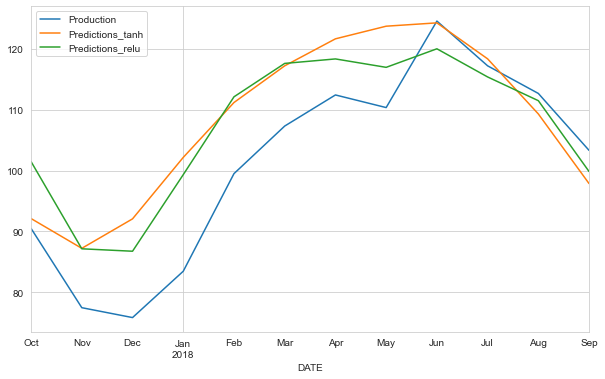

In [45]:
compare.plot()
# productiona yakin olmasi gerekiyor

In [46]:
eval_metrics(compare.Production, compare.Predictions_relu)

r2_score: 0.6577006326138071 
mae: 7.835506161647039 
mse: 80.72127167488348 
rmse: 8.984501748838579


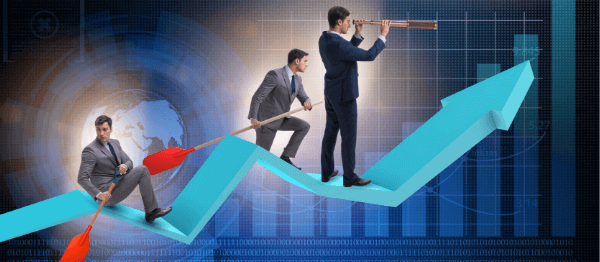

# Retrain and Forecasting

In [47]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [48]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = batch_size)

In [49]:
model = Sequential()

model.add(LSTM(64, activation = 'relu', return_sequences=True, input_shape = (length, n_features)))
model.add(LSTM(32, activation = 'relu', return_sequences=True))
model.add(LSTM(16, activation = 'relu'))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=10)

Epoch 1/10
561/561 [==============================] - 12s 13ms/step - loss: 0.0249
Epoch 2/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0105
Epoch 3/10
561/561 [==============================] - 8s 14ms/step - loss: 0.0082
Epoch 4/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0077
Epoch 5/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0077
Epoch 6/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0066
Epoch 7/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0076
Epoch 8/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0067
Epoch 9/10
561/561 [==============================] - 7s 13ms/step - loss: 0.0065
Epoch 10/10
561/561 [==============================] - 8s 13ms/step - loss: 0.0063


In [50]:
forecast = []

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)
    
    # store prediction
    forecast.append(current_pred[0]) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [current_pred], axis = 1)

In [51]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[ 87.99579406],
       [ 77.24704743],
       [ 76.72533   ],
       [ 85.70998379],
       [103.23515554],
       [115.79560214],
       [115.55751117],
       [121.31734896],
       [123.61549901],
       [111.14614795],
       [105.73790581],
       [101.33005888]])

In [52]:
df

,Production
DATE,
1972-01-01,59.962
1972-02-01,67.061
1972-03-01,74.235
1972-04-01,78.112
1972-05-01,84.764
...,...
2019-05-01,114.561
2019-06-01,124.960
2019-07-01,110.263


In [53]:
forecast_index = pd.date_range(start = '2019-10-01', periods = length, freq = 'MS')
forecast_index

DatetimeIndex(['2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01'],
              dtype='datetime64[ns]', freq='MS')

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [54]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])
forecast_df

,Forecast
2019-10-01,87.996
2019-11-01,77.247
2019-12-01,76.725
2020-01-01,85.710
2020-02-01,103.235
2020-03-01,115.796
2020-04-01,115.558
2020-05-01,121.317
2020-06-01,123.615
2020-07-01,111.146


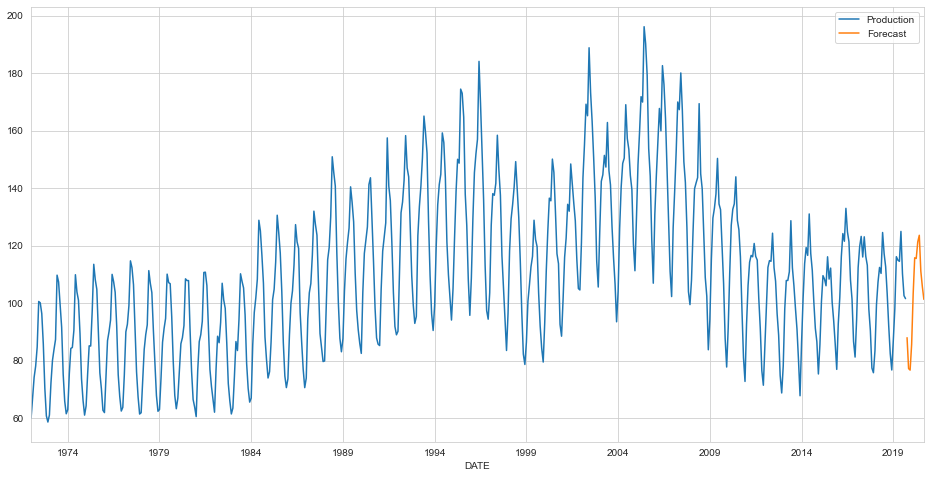

In [55]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 620.0)

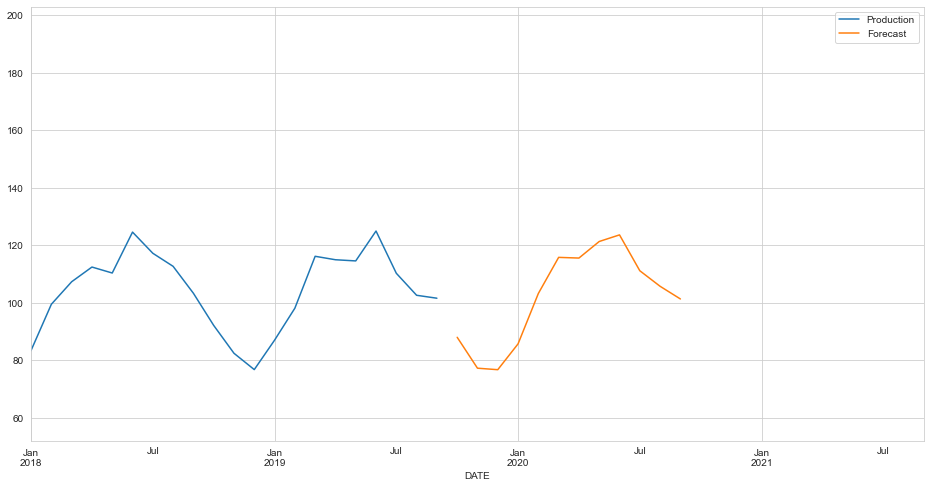

In [56]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2021-09-01')

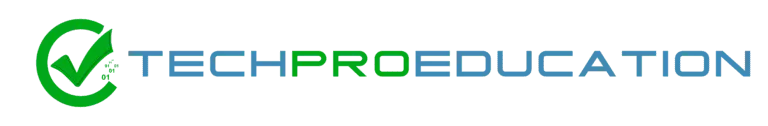